# Bayesian Hyperparameter Search

*This notebook first appeared as a [blog post](//betatim.github.io/posts/bayesian-hyperparameter-search) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2015, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

Fitting a single classifier does not take long, fitting hundreds takes a while. To find the best hyperparameters you need to fit a lot of classifiers. What to do?

This post explores the inner workings of an algorithm you can use to reduce the number of hyperparameter sets you need to try before finding the best set. The algorithm goes under the name of [bayesian optimisation](https://en.wikipedia.org/wiki/Bayesian_optimization). If you are looking for a production ready implementation check out: [MOE, metric optimisation engine](https://github.com/Yelp/MOE) developed by [Yelp](http://www.yelp.com).

Gaussian processe regression is a useful tool in general and is used heavily here. Check out my post on [Gaussian processes with george](/posts/gaussian-processes-with-george/) for a short introduction.

This post starts with an example where we know the true form of the scoring function. Followed by pitting random grid search against Bayesian optimisation to find the best hyper-parameter for a real classifier.

As usual first some setup and importing:

In [ ]:
%%bash
pip install george

In [1]:
%matplotlib inline

In [19]:
import random

import numpy as np
np.random.seed(9)

from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")

## By George!

Bayesian optimisation uses gaussian processes to fit a regression model to the previously evaluated points in hyper-parameter space. This model is then used to suggest the next (best) point in hyper-parameter space to evaluate the model at.

To choose the best point we need to define a criterion, in this case we use "expected improvement". As we only know the score to with a certain precision we do not want to simply choose the point with the best score. Instead we pick the point which promises the largest expected improvement. This allows us to incorporate the uncertainty about our estimation of the scoring function into the procedure. It leads to a mixture of exploitation and exploration of the parameter space.

Below we setup a toy scoring function ($-x\sin x$), sample a two points from it, and fit our gaussian process model to it.

In [3]:
import george
from george.kernels import ExpSquaredKernel

score_func = lambda x: -x*np.sin(x)
x = np.arange(0, 10, 0.1)

In [4]:
# Generate some fake, noisy data. These represent
# the points in hyper-parameter space for which
# we already trained our classifier and evaluated its score
xp = 10 * np.sort(np.random.rand(2))
yerr = 0.2 * np.ones_like(xp)
yp = score_func(xp) + yerr * np.random.randn(len(xp))

(<matplotlib.figure.Figure at 0x10ab63e90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10ab6f590>)

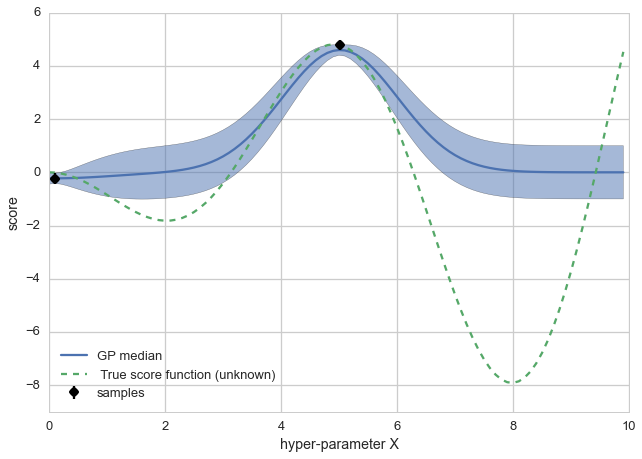

In [5]:
# Set up a Gaussian process
kernel = ExpSquaredKernel(1)
gp = george.GP(kernel)

gp.compute(xp, yerr)

mu, cov = gp.predict(yp, x)
std = np.sqrt(np.diag(cov))


def basic_plot():
    fig, ax = plt.subplots()
    ax.plot(x, mu, label="GP median")
    ax.fill_between(x, mu-std, mu+std, alpha=0.5)
    ax.plot(x, score_func(x), '--', label=" True score function (unknown)")
    # explicit zorder to draw points and errorbars on top of everything
    ax.errorbar(xp, yp, yerr=yerr, fmt='ok', zorder=3, label="samples")
    ax.set_ylim(-9,6)
    ax.set_ylabel("score")
    ax.set_xlabel('hyper-parameter X')
    ax.legend(loc='best')
    return fig,ax
basic_plot()

The dashed green line represents the true value of the scoring function as a function of our hypothetical hyper-parameter `X`. The black dots (and their errorbars) represent points at which we evaluated our classifier and calculated the score. In blue our regression model trying to predict the value of the score function. The shaded area represents the uncertainty on the median (solid blue line) value of the estimated score function value.

Next let's calculate the expected improvement at every value of the hyper-parameter `X`. We also build a multistart optimisation routine (`next_sample`) which uses the expected improvement to suggest which point to sample next.

In [6]:
from scipy.optimize import minimize
from scipy import stats

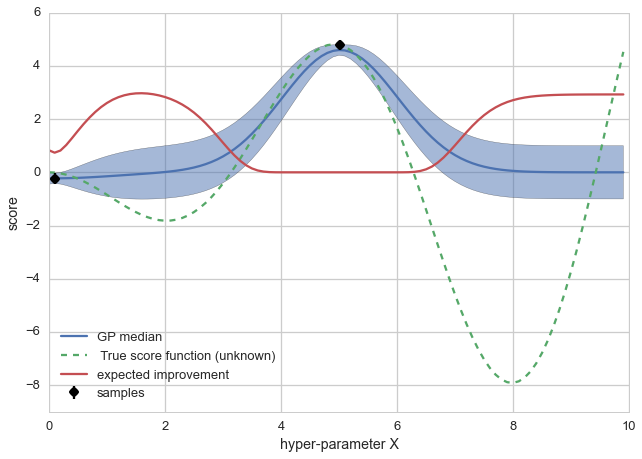

In [15]:
def expected_improvement(points, gp, samples, bigger_better=False):
    # are we trying to maximise a score or minimise an error?
    if bigger_better:
        best_sample = samples[np.argmax(samples)]

        mu, cov = gp.predict(samples, points)
        sigma = np.sqrt(cov.diagonal())

        Z = (mu-best_sample)/sigma

        ei = ((mu-best_sample) * stats.norm.cdf(Z) + sigma*stats.norm.pdf(Z))

        # want to use this as objective function in a minimiser so multiply by -1
        return -ei
    
    else:
        best_sample = samples[np.argmin(samples)]

        mu, cov = gp.predict(samples, points)
        sigma = np.sqrt(cov.diagonal())

        Z = (best_sample-mu)/sigma

        ei = ((best_sample-mu) * stats.norm.cdf(Z) + sigma*stats.norm.pdf(Z))

        # want to use this as objective function in a minimiser so multiply by -1
        return -ei

def next_sample(gp, samples, bounds=(0,10), bigger_better=False):
    """Find point with largest expected improvement"""
    best_x = None
    best_ei = 0
    # EI is zero at most values -> often get trapped
    # in a local maximum -> multistarting to increase
    # our chances to find the global maximum
    for rand_x in np.random.uniform(bounds[0], bounds[1], size=30):
        res = minimize(expected_improvement, rand_x,
                       bounds=[bounds],
                       method='L-BFGS-B',
                       args=(gp, samples, bigger_better))
        if res.fun < best_ei:
            best_ei = res.fun
            best_x = res.x[0]
            
    return best_x


fig, ax = basic_plot()
# expected improvement would need its own y axis, so just multiply by ten
ax.plot(x, 10*np.abs(expected_improvement(x, gp, yp)),
        label='expected improvement')
ax.legend(loc='best')

In [8]:
print "The algorithm suggests sampling at X=%.4f"%(next_sample(gp, yp))

The algorithm suggests sampling at X=1.5833


The red line shows the expected improvement. Comparing the solid blue line and shaded area with where the exepcted imrpovement is largest it makes sense that the optimisations suggest we should try `X=1.58` as the next point to evaluate our scoring function at.

This concludes the toy example part. Let's get moving with something real!

## Random Grid Search as Benchmark

To make this more interesting than a complete toy example, let's use a regression problem (Friedman1) and a single `DecisionTreeRegressor`, even though it is fairly fast to fit lots of classifiers on this dataset. Replace both by your setup for your actual problem.

To judge how much more quickly we find the best set of hyperparameters we will pit bayesian optimisation against random grid search. Random grid search is already a big improvement over an exhaustive grid search. I have taken the particular regression problem from [Gilles Louppe](//twitter.com/glouppe)'s PhD thesis: [Understanding Random Forests: From Theory to Practice](http://orbi.ulg.ac.be/handle/2268/170309).

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor

from operator import itemgetter


# Load the data
X, y = make_friedman1(n_samples=5000)


clf = DecisionTreeRegressor()

param_dist = {"min_samples_split": sp_randint(1, 101),
             }

# run randomized search
n_iterations = 8

random_grid = RandomizedSearchCV(clf,
                                 param_distributions=param_dist,
                                 n_iter=n_iterations,
                                 scoring='mean_squared_error')
random_grid = random_grid.fit(X, y)

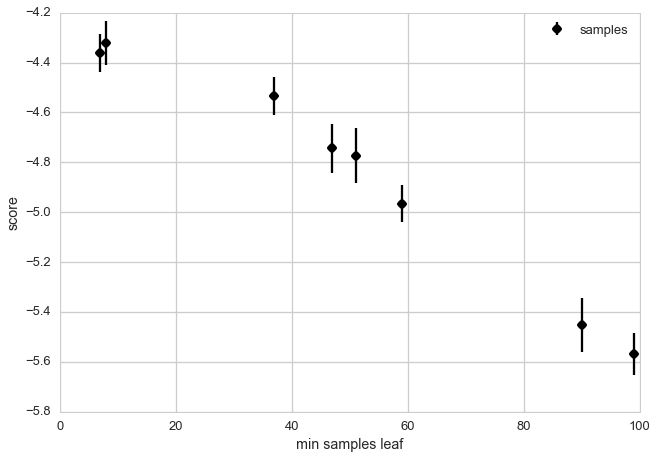

In [76]:
from scipy.stats import sem

params_ = []
scores_ = []
yerr_ = []
for g in random_grid.grid_scores_:
    params_.append(g.parameters.values()[0])
    scores_.append(g.mean_validation_score)
    yerr_.append(sem(g.cv_validation_scores))

fig, ax = plt.subplots()
ax.errorbar(params_, scores_, yerr=yerr_, fmt='ok', label='samples')
ax.set_ylabel("score")
ax.set_xlabel('min samples leaf')
ax.legend(loc='best')

With eight evaluations we get a fairly good idea what the score function looks like for this problem. Potentially 1 is the best solution, otherwise steeply falling. The best hyper-parameter setting in this case is eight.

You can see that the search explores all values of `min_samples_leaf` with equal probability.

In [17]:
def top_parameters(random_grid_cv):
    top_score = sorted(random_grid_cv.grid_scores_,
                       key=itemgetter(1),
                       reverse=True)[0]
    print "Mean validation score: {0:.3f} +- {1:.3f}".format(
        top_score.mean_validation_score,
        np.std(top_score.cv_validation_scores))
    print random_grid_cv.best_params_
    
top_parameters(random_grid)

Mean validation score: -4.322 +- 0.127
{'min_samples_split': 8}


The top scoring parameter is around eight. Let's see what we can do with a bayesian approach.

## Bayesian optimisation

Do you have your priors ready? Let's get Bayesian! The question is, can we find at least as good a value for `min_samples_split` or a better one in eight or less attempts of training a model.

To get things started we evaluate the model at three points of the hyper-parameter. There are used for the first fit of our gaussian process model. The next point at which to evaluate the model is then the point where the expected improvement is largest.

The below two plots show the state of the bayesian optimisation after the first three points are tried and then after the five points choosen according to the expected improvement.

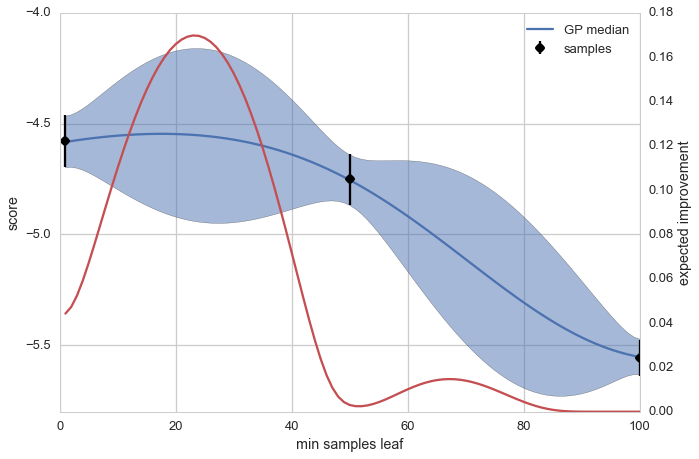

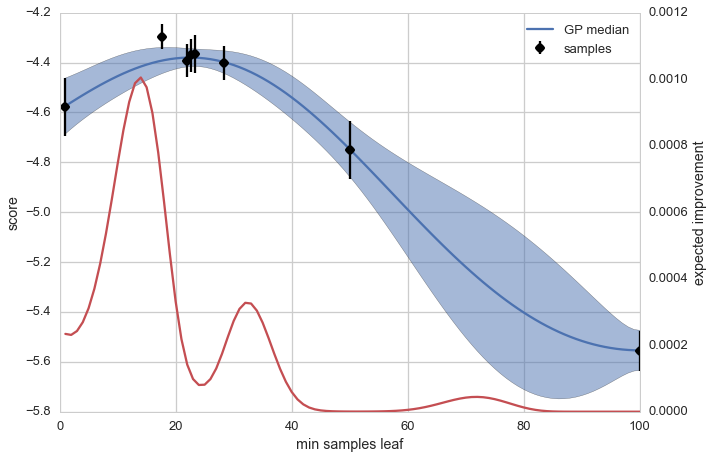

In [70]:
from sklearn.cross_validation import cross_val_score

def plot_optimisation(gp, x, params, scores, yerr):
    mu, cov = gp.predict(scores, x)
    std = np.sqrt(np.diag(cov))

    fig, ax = plt.subplots()
    ax.plot(x, mu, label="GP median")
    ax.fill_between(x, mu-std, mu+std, alpha=0.5)

    ax_r = ax.twinx()
    ax_r.grid(False)
    ax_r.plot(x,
              np.abs(expected_improvement(x, gp, scores, bigger_better=True)),
              label='expected improvement',
              c=sns.color_palette()[2])
    ax_r.set_ylabel("expected improvement")
    
    # explicit zorder to draw points and errorbars on top of everything
    ax.errorbar(params, scores, yerr=yerr,
                fmt='ok', zorder=3, label='samples')
    ax.set_ylabel("score")
    ax.set_xlabel('min samples leaf')
    ax.legend(loc='best')
    return gp

def bayes_optimise(clf, X,y, parameter, n_iterations, bounds):
    x = range(bounds[0], bounds[1]+1)
    
    params = []
    scores = []
    yerr = []
    
    for param in np.linspace(bounds[0], bounds[1], 3, dtype=int):
        clf.set_params(**{parameter: param})
        cv_scores = cross_val_score(clf, X,y, scoring='mean_squared_error')
        params.append(param)
        scores.append(np.mean(cv_scores))
        yerr.append(sem(cv_scores))
    
    # Some cheating here, tuning the GP hyperparameters is something
    # we skip in this post
    kernel = ExpSquaredKernel(1000)
    gp = george.GP(kernel, mean=np.mean(scores))
    gp.compute(params, yerr)
    
    plot_optimisation(gp, x, params, scores, yerr)
        
    for n in range(n_iterations-3):
        gp.compute(params, yerr)
        param = next_sample(gp, scores, bounds=bounds, bigger_better=True)
        
        clf.set_params(**{parameter: param})
        cv_scores = cross_val_score(clf, X,y, scoring='mean_squared_error')
        params.append(param)
        scores.append(np.mean(cv_scores))
        yerr.append(sem(cv_scores))
        
    plot_optimisation(gp, x, params, scores, yerr)
    return params, scores, yerr, clf

params, scores, yerr, clf = bayes_optimise(DecisionTreeRegressor(),
                                           X,y,
                                           'min_samples_split',
                                           8, (1,100))

In [72]:
print "Best parameter:"
print params[np.argmax(scores)], 'scores', scores[np.argmax(scores)]

Best parameter:
17.721702255 scores -4.29572348033


You can see that the points are all sampled close to the maximum. Where as the random grid search samples points far away from the peak (above 40 and beyond), the bayesian optimisation concentrates on the region close to the maximum (around 20). This vastly improves the efficiency of finding the true maximum. We could have even stopped before evaluating all of the next five points. They are all pretty close to each other.

## The real deal --- MOE

While it is quite straightforward to build yourself a small bayesian optimisation procedure, I would recommend you check out [MOE](https://github.com/Yelp/MOE). This is a production quality setup for doing global, black box optimisation. It is developed by the good guys at Yelp!. Therefore much more robust than our home made solution.

## Conclusions

Bayesian optimisation is not scary. With the two examples here you should be convinced that using a smart approach like this is faster than a random grid search (especially in higher dimensions) and that there is nothing magic going on.

---
If you find a mistake or want to tell me something else get in touch on twitter @[betatim](//twitter.com/betatim)